In [1]:
%load_ext autoreload
import sys, os
COLAB = 'google.colab' in sys.modules 
if COLAB:
    %pip install git+https://github.com/UlisseMini/procgen-tools

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
import torch
from IPython import display
from glob import glob
import pickle
from tqdm import tqdm
import os
from collections import defaultdict

from procgen_tools import maze, models
from procgen_tools.episodes import Episode, load_episode
from procgen_tools.metrics import metrics, decision_square

In [6]:
files = glob('../episode_data/*region_5*.pkl')
runs = []
load_venv = False
for f in tqdm(files):
    try:
        ep = load_episode(f, load_venv=load_venv)
        runs.append(ep)
        # with open(f, 'wb') as fp:
        #     pickle.dump(ep.__getstate__(), fp, protocol=pickle.HIGHEST_PROTOCOL)
    except (AssertionError, KeyError) as e:
        print(f"Malformed file {f}: {e}")
        #os.remove(f)

len(runs)

100%|██████████| 10000/10000 [00:01<00:00, 7063.38it/s]


0

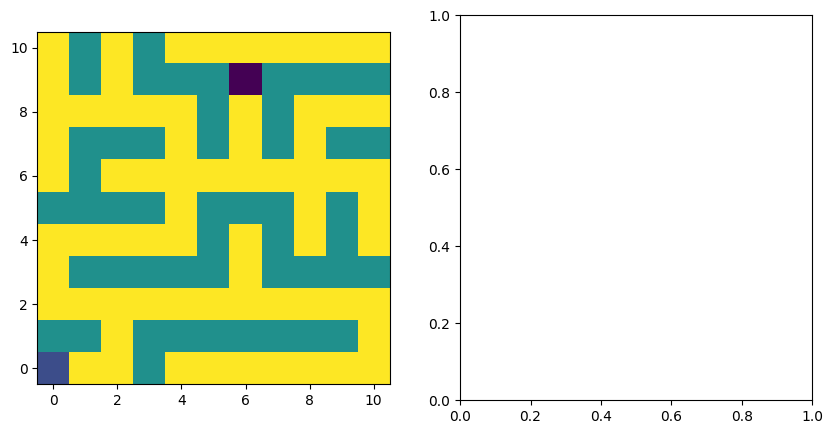

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
R = 3
ax[0].imshow(runs[R].grid(), origin='lower')
if load_venv: ax[1].imshow(runs[R]["start_info"]["rgb"])
plt.show()

## Graph metrics on all grids

In [5]:
recorded_metrics = defaultdict(list)
got_cheese = []
for run in tqdm(runs):
    g = run.grid()
    if decision_square(g) is None or (g[-5:, -5:] == maze.CHEESE).any():
        continue
    for name, metric in metrics.items():
        recorded_metrics[name].append(metric(g))
    got_cheese.append(float(run.got_cheese))

got_cheese = np.array(got_cheese)
len(got_cheese)

 26%|██▋       | 2635/10000 [00:35<01:40, 73.58it/s] 


KeyboardInterrupt: 

In [ ]:
for name, metric in recorded_metrics.items():
    recorded_metrics[name] = np.array(metric)

In [ ]:
prob = sum(got_cheese) / len(got_cheese)
print(f'P(get cheese | decision square, cheese not in top 5x5) = {prob}')

P(get cheese | decision square, cheese not in top 5x5) = 0.5789679437060203


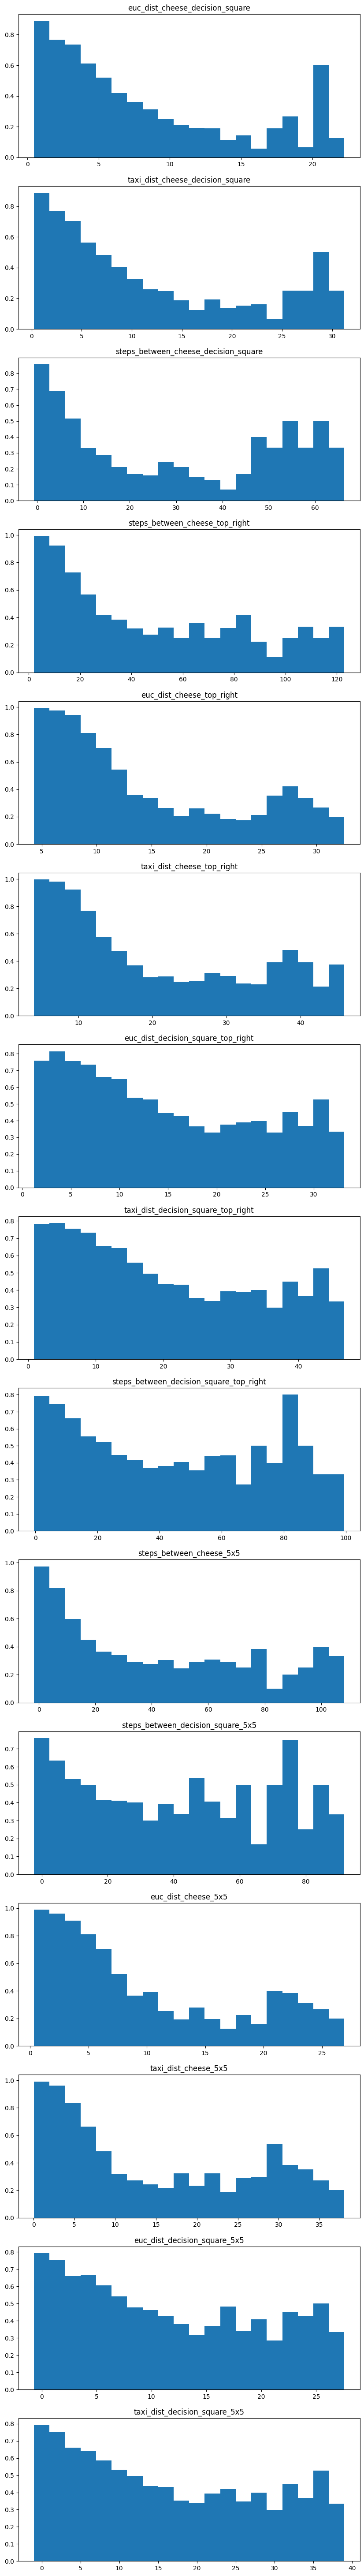

In [ ]:
# Use matplotlib to plot all recorded_metrics by name (key) vertically in a single figure
fig, ax = plt.subplots(len(recorded_metrics), 1, figsize=(10, 5*len(recorded_metrics)))
for i, (name, values) in enumerate(recorded_metrics.items()):
    bins, edges = np.histogram(values, bins=20)
    percentages = []
    for j, (num_runs_in_this_bin, edge) in enumerate(zip(bins, edges)):
        successes = sum(got_cheese[np.logical_and(values >= edges[j], values < edges[j+1])]) 
        # laplace's rule of succession avoids devision-by-zero,
        # and gives a better estimate of P(get cheese | metric in this bin).
        percentages.append((successes+1) / (num_runs_in_this_bin+2))
    ax[i].bar(edges[:-1], percentages, width=edges[1]-edges[0])
    ax[i].set_title(name)
  
plt.show()

## Replay a run

KeyboardInterrupt: 

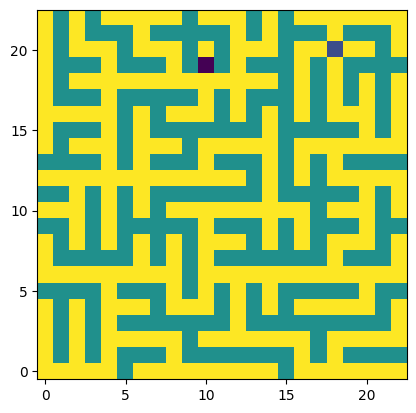

In [ ]:
r = runs[0]
for t in range(0, r.steps):
    grid = r.grid(t)
    plt.imshow(grid, origin='lower')
    display.display(plt.gcf())
    display.clear_output(wait=True)